In [5]:
import os
from os.path import join
import imageio
import climlab
import calendar
import numpy as np
import pandas as pd
import xarray as xr
import datetime
from datetime import timedelta
import pandas as pd
from scipy import signal
# import pyts
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cross_decomposition import CCA
# from pyts.approximation import DiscreteFourierTransform
import nc_time_axis  # dark magic CFTime library

In [6]:
# style
from IPython.display import display, HTML, Image
display(HTML("<style>.container { width:100% !important; }</style>"))

import seaborn as sns
from matplotlib.cm import ScalarMappable
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 90  # finer plotting
# %matplotlib inline
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point
import warnings
# matplotlib contourf was warning that add_colorbar was not being used in ax[i].contourf
warnings.filterwarnings("ignore")

sns.set_theme()
sns.set_context("paper")
os.getcwd()

'/Users/lukebrown/Library/Mobile Documents/com~apple~CloudDocs/repos/clim_phys/climate_students_eoas/content/courseware/assignments'

In [7]:
def compute_regional_anomaly(dataset, climate_variable, weight_factor, time_period=(None, None), 
                             roll_time=12, region=(None, None, None, None)):
    lat1, lat2, lon1, lon2 = region
    begin, end = time_period
    
    od_nino34 = dataset[climate_variable].sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))  # region select
    gb = od_nino34[climate_variable].groupby('time.month')  # group months
    gb_period = od_nino34[climate_variable].sel(time=slice(begin, end))  # optional historical period selection
    monthly_mean = gb_period.groupby('time.month').mean(dim='time')  # monthly means
    od_nino34_anom = gb - monthly_mean.broadcast_like(od_nino34[climate_variable])  # get anomalies
    index_nino34 = (od_nino34_anom * weight_factor).mean(  # grid-cell weighted regional mean
        dim=['lat', 'lon']).rolling(
        time=roll_time, center=True).mean() / od_nino34[climate_variable].std()
    
    return od_nino34_anom, index_nino34


# Compute R^2 between wind speeds, ENSO, and NAO

In [15]:
el_nino = dcpp_ensemble.ts_dcpp.dropna(dim='time').values.reshape(-1, 1)
wind_speed = dcpp_ensemble.uas_dcpp.dropna(dim='time').values.reshape(-1, 1)
cca = CCA(n_components=1)

cca_list.append(cca.fit(wind_speed, el_nino))
cca_scores.append(cca.score(wind_speed, el_nino))

np.array(cca_scores).mean()

0.9198864316391975

# Open archived datasets

In [14]:
hnat_ensemble = xr.open_dataset('hnat_ensemble_complete_w_separate.nc')
hist_ensemble = xr.open_dataset('hist_ensemble_complete_w_separate.nc')
dcpp_ensemble = xr.open_dataset('dcpp_ensemble_complete.nc')
dcpp_ensemble

<xarray.Dataset>
Dimensions:        (time: 120)
Coordinates:
  * time           (time) object 2015-01-16 12:00:00 ... 2024-12-16 12:00:00
    month          (time) int64 ...
    height         (time) float64 ...
Data variables: (12/14)
    grfs_dcpp      (time) float64 ...
    grfs_dcpp_std  (time) float64 ...
    ts_dcpp        (time) float64 ...
    ts_dcpp_std    (time) float64 ...
    uas_dcpp       (time) float64 ...
    uas_dcpp_std   (time) float64 ...
    ...             ...
    mrfs_dcpp      (time) float64 ...
    mrfs_dcpp_std  (time) float64 ...
    nao_dcpp       (time) float64 ...
    nao_dcpp_std   (time) float64 ...
    vas_dcpp       (time) float64 ...
    vas_dcpp_std   (time) float64 ...

# ENSO Response, eastward wind, global radiative forcing

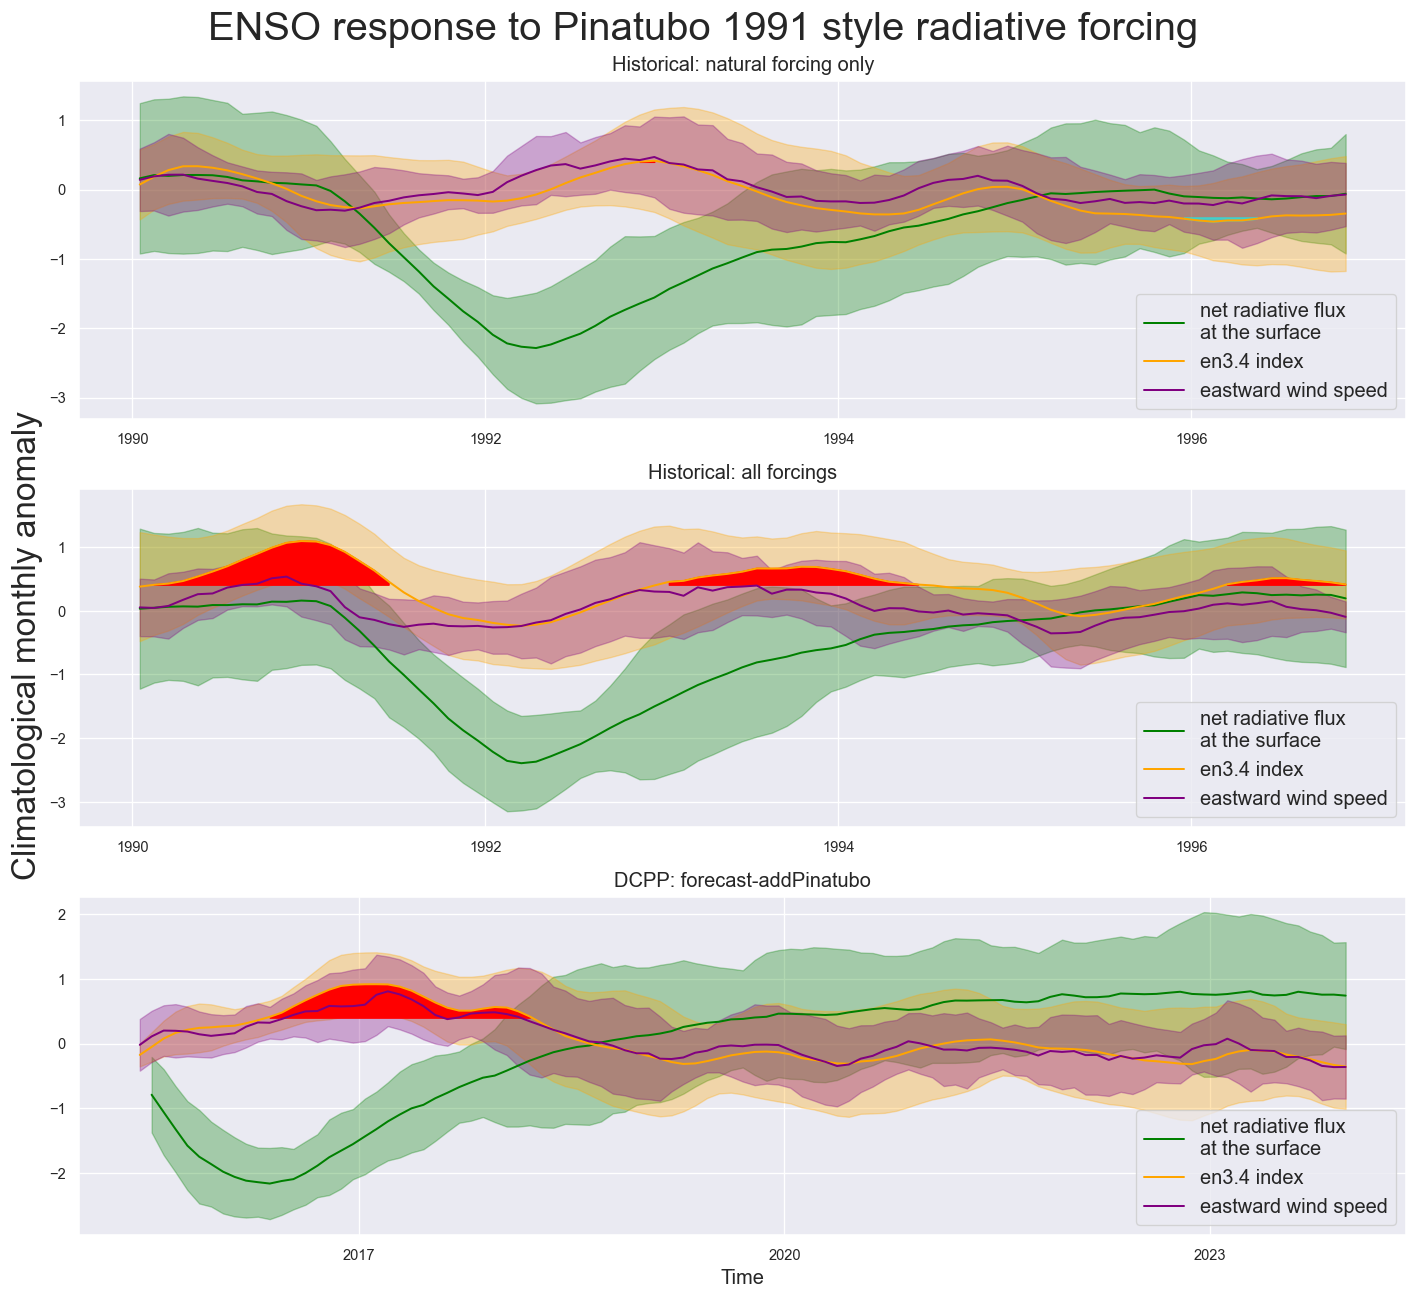

In [10]:

# HNAT
begin = '1990-01-01'
end = '1996-12-01'

fontsize = 12

# plot the ensemble mean and standard deviation
fig, ax = plt.subplots(3, 1, figsize=(12, 11), dpi=120)
ax[0].plot(
    hnat_ensemble.grfs_hnat.sel(time=slice(begin, end)).time.values,
    hnat_ensemble.grfs_hnat.sel(time=slice(begin, end)).values,
    label='net radiative flux\nat the surface', color='green')
ax[0].fill_between(hnat_ensemble.grfs_hnat.sel(time=slice(begin, end)).time.values,  
                 hnat_ensemble.grfs_hnat.sel(time=slice(begin, end)) - hnat_ensemble.grfs_hnat_std.sel(time=slice(begin, end)), 
                 hnat_ensemble.grfs_hnat.sel(time=slice(begin, end)) + hnat_ensemble.grfs_hnat_std.sel(time=slice(begin, end)), 
                 alpha=0.3, color='green')
ax[0].plot(
    hnat_ensemble.ts_hnat.sel(time=slice(begin, end)).time.values,
    hnat_ensemble.ts_hnat.sel(time=slice(begin, end)).values,
    label='en3.4 index', color='orange')
ax[0].fill_between(hnat_ensemble.ts_hnat.sel(time=slice(begin, end)).time.values,  
                 hnat_ensemble.ts_hnat.sel(time=slice(begin, end)) - hnat_ensemble.ts_hnat_std.sel(time=slice(begin, end)), 
                 hnat_ensemble.ts_hnat.sel(time=slice(begin, end)) + hnat_ensemble.ts_hnat_std.sel(time=slice(begin, end)), 
                 alpha=0.3, color='orange')
ax[0].plot(
    hnat_ensemble.uas_hnat.sel(time=slice(begin, end)).time.values,
    hnat_ensemble.uas_hnat.sel(time=slice(begin, end)).values,
    label='eastward wind speed', color='purple')
ax[0].fill_between(hnat_ensemble.uas_hnat.sel(time=slice(begin, end)).time.values,  
                 hnat_ensemble.uas_hnat.sel(time=slice(begin, end)) - hnat_ensemble.uas_hnat_std.sel(time=slice(begin, end)), 
                 hnat_ensemble.uas_hnat.sel(time=slice(begin, end)) + hnat_ensemble.uas_hnat_std.sel(time=slice(begin, end)), 
                 alpha=0.3, color='purple')
ax[0].fill_between(
    hnat_ensemble.ts_hnat.sel(time=slice(begin, end)).time.values,
    hnat_ensemble.ts_hnat.sel(time=slice(begin, end)).where(
        hnat_ensemble.ts_hnat.sel(time=slice(begin, end)) >= 0.4
    ),
    0.4,
    color='red',
    alpha=1.0,
)
ax[0].fill_between(
    hnat_ensemble.ts_hnat.sel(time=slice(begin, end)).time.values,
    hnat_ensemble.ts_hnat.sel(time=slice(begin, end)).where(
        hnat_ensemble.ts_hnat.sel(time=slice(begin, end)) <= -0.4
    ),
    -0.4,
    color='aqua',
    alpha=0.5,
)
ax[0].legend(loc='lower right', fontsize=fontsize)


# HIST

ax[1].plot(
    hist_ensemble.grfs_hist.sel(time=slice(begin, end)).time.values,
    hist_ensemble.grfs_hist.sel(time=slice(begin, end)).values,
    label='net radiative flux\nat the surface', color='green')
ax[1].fill_between(hist_ensemble.grfs_hist.sel(time=slice(begin, end)).time.values,  
                 hist_ensemble.grfs_hist.sel(time=slice(begin, end)) - hist_ensemble.grfs_hist_std.sel(time=slice(begin, end)), 
                 hist_ensemble.grfs_hist.sel(time=slice(begin, end)) + hist_ensemble.grfs_hist_std.sel(time=slice(begin, end)), 
                 alpha=0.3, color='green')
ax[1].plot(
    hist_ensemble.ts_hist.sel(time=slice(begin, end)).time.values,
    hist_ensemble.ts_hist.sel(time=slice(begin, end)).values,
    label='en3.4 index', color='orange')
ax[1].fill_between(hist_ensemble.ts_hist.sel(time=slice(begin, end)).time.values,  
                 hist_ensemble.ts_hist.sel(time=slice(begin, end)) - hist_ensemble.ts_hist_std.sel(time=slice(begin, end)), 
                 hist_ensemble.ts_hist.sel(time=slice(begin, end)) + hist_ensemble.ts_hist_std.sel(time=slice(begin, end)), 
                 alpha=0.3, color='orange')
ax[1].plot(
    hist_ensemble.uas_hist.sel(time=slice(begin, end)).time.values,
    hist_ensemble.uas_hist.sel(time=slice(begin, end)).values,
    label='eastward wind speed', color='purple')
ax[1].fill_between(hist_ensemble.uas_hist.sel(time=slice(begin, end)).time.values,  
                 hist_ensemble.uas_hist.sel(time=slice(begin, end)) - hist_ensemble.uas_hist_std.sel(time=slice(begin, end)), 
                 hist_ensemble.uas_hist.sel(time=slice(begin, end)) + hist_ensemble.uas_hist_std.sel(time=slice(begin, end)), 
                 alpha=0.3, color='purple')
ax[1].fill_between(
    hist_ensemble.ts_hist.sel(time=slice(begin, end)).time.values,
    hist_ensemble.ts_hist.sel(time=slice(begin, end)).where(
        hist_ensemble.ts_hist.sel(time=slice(begin, end)) >= 0.4
    ),
    0.4,
    color='red',
    alpha=1.0,
)
ax[1].fill_between(
    hist_ensemble.ts_hist.sel(time=slice(begin, end)).time.values,
    hist_ensemble.ts_hist.sel(time=slice(begin, end)).where(
        hist_ensemble.ts_hist.sel(time=slice(begin, end)) <= -0.4
    ),
    -0.4,
    color='aqua',
    alpha=0.5,
)

ax[1].legend(loc='lower right', fontsize=fontsize)


# DCPP
begin = '2015-06-01'
end = '2024-01-01'

ax[2].plot(
    dcpp_ensemble.grfs_dcpp.sel(time=slice(begin, end)).time.values,
    dcpp_ensemble.grfs_dcpp.sel(time=slice(begin, end)).values,
    label='net radiative flux\nat the surface', color='green')
ax[2].fill_between(dcpp_ensemble.grfs_dcpp.sel(time=slice(begin, end)).time.values,  
                 dcpp_ensemble.grfs_dcpp.sel(time=slice(begin, end)) - dcpp_ensemble.grfs_dcpp_std.sel(time=slice(begin, end)), 
                 dcpp_ensemble.grfs_dcpp.sel(time=slice(begin, end)) + dcpp_ensemble.grfs_dcpp_std.sel(time=slice(begin, end)), 
                 alpha=0.3, color='green')
ax[2].plot(
    dcpp_ensemble.ts_dcpp.sel(time=slice(begin, end)).time.values,
    dcpp_ensemble.ts_dcpp.sel(time=slice(begin, end)).values,
    label='en3.4 index', color='orange')
ax[2].fill_between(dcpp_ensemble.ts_dcpp.sel(time=slice(begin, end)).time.values,  
                 dcpp_ensemble.ts_dcpp.sel(time=slice(begin, end)) - dcpp_ensemble.ts_dcpp_std.sel(time=slice(begin, end)), 
                 dcpp_ensemble.ts_dcpp.sel(time=slice(begin, end)) + dcpp_ensemble.ts_dcpp_std.sel(time=slice(begin, end)), 
                 alpha=0.3, color='orange')
ax[2].plot(
    dcpp_ensemble.uas_dcpp.sel(time=slice(begin, end)).time.values,
    dcpp_ensemble.uas_dcpp.sel(time=slice(begin, end)).values,
    label='eastward wind speed', color='purple')
ax[2].fill_between(dcpp_ensemble.uas_dcpp.sel(time=slice(begin, end)).time.values,  
                 dcpp_ensemble.uas_dcpp.sel(time=slice(begin, end)) - dcpp_ensemble.uas_dcpp_std.sel(time=slice(begin, end)), 
                 dcpp_ensemble.uas_dcpp.sel(time=slice(begin, end)) + dcpp_ensemble.uas_dcpp_std.sel(time=slice(begin, end)), 
                 alpha=0.3, color='purple')
ax[2].fill_between(
    dcpp_ensemble.ts_dcpp.sel(time=slice(begin, end)).time.values,
    dcpp_ensemble.ts_dcpp.sel(time=slice(begin, end)).where(
        dcpp_ensemble.ts_dcpp.sel(time=slice(begin, end)) >= 0.4
    ),
    0.4,
    color='red',
    alpha=1.0,
)
ax[2].fill_between(
    dcpp_ensemble.ts_dcpp.sel(time=slice(begin, end)).time.values,
    dcpp_ensemble.ts_dcpp.sel(time=slice(begin, end)).where(
        dcpp_ensemble.ts_dcpp.sel(time=slice(begin, end)) <= -0.4
    ),
    -0.4,
    color='aqua',
    alpha=0.5,
)
plt.suptitle("ENSO response to Pinatubo 1991 style radiative forcing", fontsize=24)
ax[0].set_title("Historical: natural forcing only", fontsize=fontsize)
ax[1].set_title("Historical: all forcings", fontsize=fontsize)
ax[2].set_title("DCPP: forecast-addPinatubo", fontsize=fontsize)
ax[2].set_xlabel("Time", fontsize=fontsize)
fig.supylabel('Climatological monthly anomaly', fontsize=20)

ax[2].legend(loc='lower right', fontsize=fontsize)
plt.tight_layout()
# plt.savefig("test_vrf30N80N_uas_nao_allsims_1990_1996_2015_2024_timeseries_v2.png")
plt.show()


# Mid-to-High latitude forcing, NAO response, northward wind

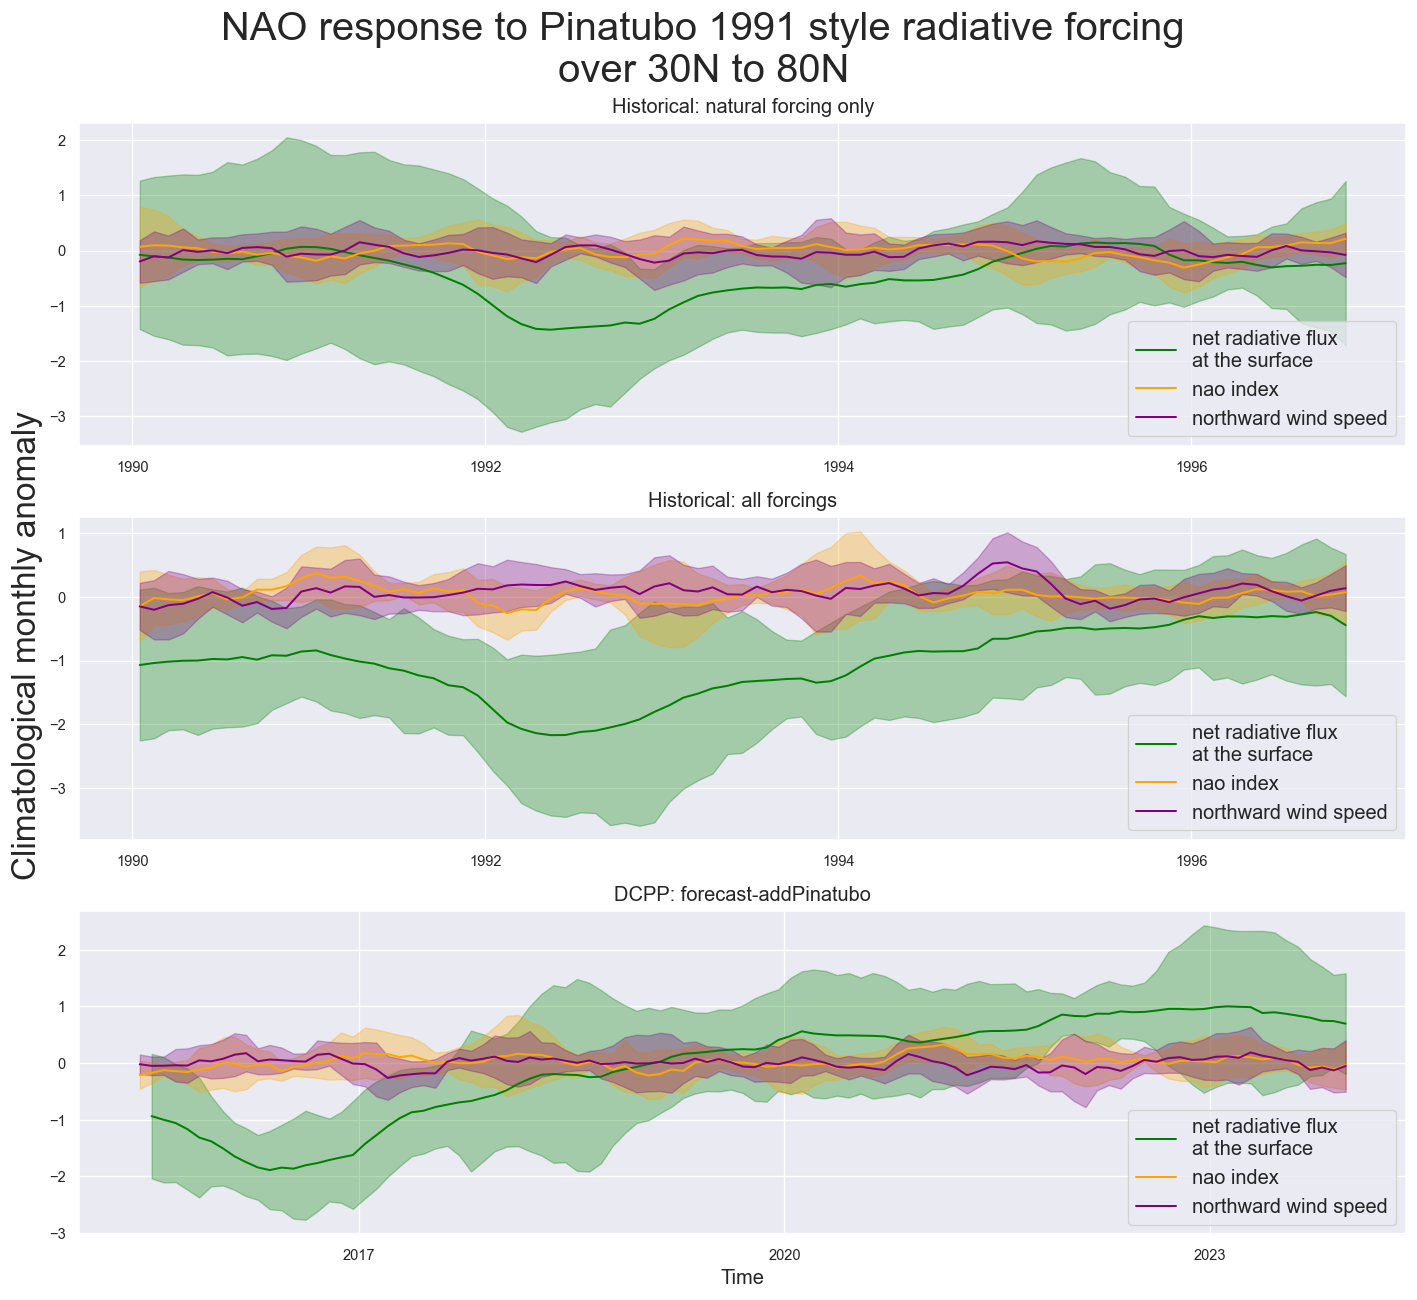

In [12]:

# HNAT
begin = '1990-01-01'
end = '1996-12-01'

fontsize = 12

# plot the ensemble mean and standard deviation
fig, ax = plt.subplots(3, 1, figsize=(12, 11), dpi=120)
ax[0].plot(
    hnat_ensemble.mrfs_hnat.sel(time=slice(begin, end)).time.values,
    hnat_ensemble.mrfs_hnat.sel(time=slice(begin, end)).values,
    label='net radiative flux\nat the surface', color='green')
ax[0].fill_between(hnat_ensemble.mrfs_hnat.sel(time=slice(begin, end)).time.values,  
                 hnat_ensemble.mrfs_hnat.sel(time=slice(begin, end)) - hnat_ensemble.mrfs_hnat_std.sel(time=slice(begin, end)), 
                 hnat_ensemble.mrfs_hnat.sel(time=slice(begin, end)) + hnat_ensemble.mrfs_hnat_std.sel(time=slice(begin, end)), 
                 alpha=0.3, color='green')
ax[0].plot(
    hnat_ensemble.nao_hnat.sel(time=slice(begin, end)).time.values,
    hnat_ensemble.nao_hnat.sel(time=slice(begin, end)).values,
    label='nao index', color='orange')
ax[0].fill_between(hnat_ensemble.nao_hnat.sel(time=slice(begin, end)).time.values,  
                 hnat_ensemble.nao_hnat.sel(time=slice(begin, end)) - hnat_ensemble.nao_hnat_std.sel(time=slice(begin, end)), 
                 hnat_ensemble.nao_hnat.sel(time=slice(begin, end)) + hnat_ensemble.nao_hnat_std.sel(time=slice(begin, end)), 
                 alpha=0.3, color='orange')
ax[0].plot(
    hnat_ensemble.vas_hnat.sel(time=slice(begin, end)).time.values,
    hnat_ensemble.vas_hnat.sel(time=slice(begin, end)).values,
    label='northward wind speed', color='purple')
ax[0].fill_between(hnat_ensemble.vas_hnat.sel(time=slice(begin, end)).time.values,  
                 hnat_ensemble.vas_hnat.sel(time=slice(begin, end)) - hnat_ensemble.vas_hnat_std.sel(time=slice(begin, end)), 
                 hnat_ensemble.vas_hnat.sel(time=slice(begin, end)) + hnat_ensemble.vas_hnat_std.sel(time=slice(begin, end)), 
                 alpha=0.3, color='purple')

ax[0].legend(loc='lower right', fontsize=fontsize)


# HIST

ax[1].plot(
    hist_ensemble.mrfs_hist.sel(time=slice(begin, end)).time.values,
    hist_ensemble.mrfs_hist.sel(time=slice(begin, end)).values,
    label='net radiative flux\nat the surface', color='green')
ax[1].fill_between(hist_ensemble.mrfs_hist.sel(time=slice(begin, end)).time.values,  
                 hist_ensemble.mrfs_hist.sel(time=slice(begin, end)) - hist_ensemble.mrfs_hist_std.sel(time=slice(begin, end)), 
                 hist_ensemble.mrfs_hist.sel(time=slice(begin, end)) + hist_ensemble.mrfs_hist_std.sel(time=slice(begin, end)), 
                 alpha=0.3, color='green')
ax[1].plot(
    hist_ensemble.nao_hist.sel(time=slice(begin, end)).time.values,
    hist_ensemble.nao_hist.sel(time=slice(begin, end)).values,
    label='nao index', color='orange')
ax[1].fill_between(hist_ensemble.nao_hist.sel(time=slice(begin, end)).time.values,  
                 hist_ensemble.nao_hist.sel(time=slice(begin, end)) - hist_ensemble.nao_hist_std.sel(time=slice(begin, end)), 
                 hist_ensemble.nao_hist.sel(time=slice(begin, end)) + hist_ensemble.nao_hist_std.sel(time=slice(begin, end)), 
                 alpha=0.3, color='orange')
ax[1].plot(
    hist_ensemble.vas_hist.sel(time=slice(begin, end)).time.values,
    hist_ensemble.vas_hist.sel(time=slice(begin, end)).values,
    label='northward wind speed', color='purple')
ax[1].fill_between(hist_ensemble.vas_hist.sel(time=slice(begin, end)).time.values,  
                 hist_ensemble.vas_hist.sel(time=slice(begin, end)) - hist_ensemble.vas_hist_std.sel(time=slice(begin, end)), 
                 hist_ensemble.vas_hist.sel(time=slice(begin, end)) + hist_ensemble.vas_hist_std.sel(time=slice(begin, end)), 
                 alpha=0.3, color='purple')

ax[1].legend(loc='lower right', fontsize=fontsize)


# DCPP
begin = '2015-06-01'
end = '2024-01-01'

ax[2].plot(
    dcpp_ensemble.mrfs_dcpp.sel(time=slice(begin, end)).time.values,
    dcpp_ensemble.mrfs_dcpp.sel(time=slice(begin, end)).values,
    label='net radiative flux\nat the surface', color='green')
ax[2].fill_between(dcpp_ensemble.mrfs_dcpp.sel(time=slice(begin, end)).time.values,  
                 dcpp_ensemble.mrfs_dcpp.sel(time=slice(begin, end)) - dcpp_ensemble.mrfs_dcpp_std.sel(time=slice(begin, end)), 
                 dcpp_ensemble.mrfs_dcpp.sel(time=slice(begin, end)) + dcpp_ensemble.mrfs_dcpp_std.sel(time=slice(begin, end)), 
                 alpha=0.3, color='green')
ax[2].plot(
    dcpp_ensemble.nao_dcpp.sel(time=slice(begin, end)).time.values,
    dcpp_ensemble.nao_dcpp.sel(time=slice(begin, end)).values,
    label='nao index', color='orange')
ax[2].fill_between(dcpp_ensemble.nao_dcpp.sel(time=slice(begin, end)).time.values,  
                 dcpp_ensemble.nao_dcpp.sel(time=slice(begin, end)) - dcpp_ensemble.nao_dcpp_std.sel(time=slice(begin, end)), 
                 dcpp_ensemble.nao_dcpp.sel(time=slice(begin, end)) + dcpp_ensemble.nao_dcpp_std.sel(time=slice(begin, end)), 
                 alpha=0.3, color='orange')
ax[2].plot(
    dcpp_ensemble.vas_dcpp.sel(time=slice(begin, end)).time.values,
    dcpp_ensemble.vas_dcpp.sel(time=slice(begin, end)).values,
    label='northward wind speed', color='purple')
ax[2].fill_between(dcpp_ensemble.vas_dcpp.sel(time=slice(begin, end)).time.values,  
                 dcpp_ensemble.vas_dcpp.sel(time=slice(begin, end)) - dcpp_ensemble.vas_dcpp_std.sel(time=slice(begin, end)), 
                 dcpp_ensemble.vas_dcpp.sel(time=slice(begin, end)) + dcpp_ensemble.vas_dcpp_std.sel(time=slice(begin, end)), 
                 alpha=0.3, color='purple')

plt.suptitle("NAO response to Pinatubo 1991 style radiative forcing\nover 30N to 80N", fontsize=24)
ax[0].set_title("Historical: natural forcing only", fontsize=fontsize)
ax[1].set_title("Historical: all forcings", fontsize=fontsize)
ax[2].set_title("DCPP: forecast-addPinatubo", fontsize=fontsize)
ax[2].set_xlabel("Time", fontsize=fontsize)
fig.supylabel('Climatological monthly anomaly', fontsize=20)

ax[2].legend(loc='lower right', fontsize=fontsize)
plt.tight_layout()
# plt.savefig("test_vrf30N80N_uas_nao_allsims_1990_1996_2015_2024_timeseries_v2.png")
plt.show()


# Tropical forcing, ENSO separated by entrance phase

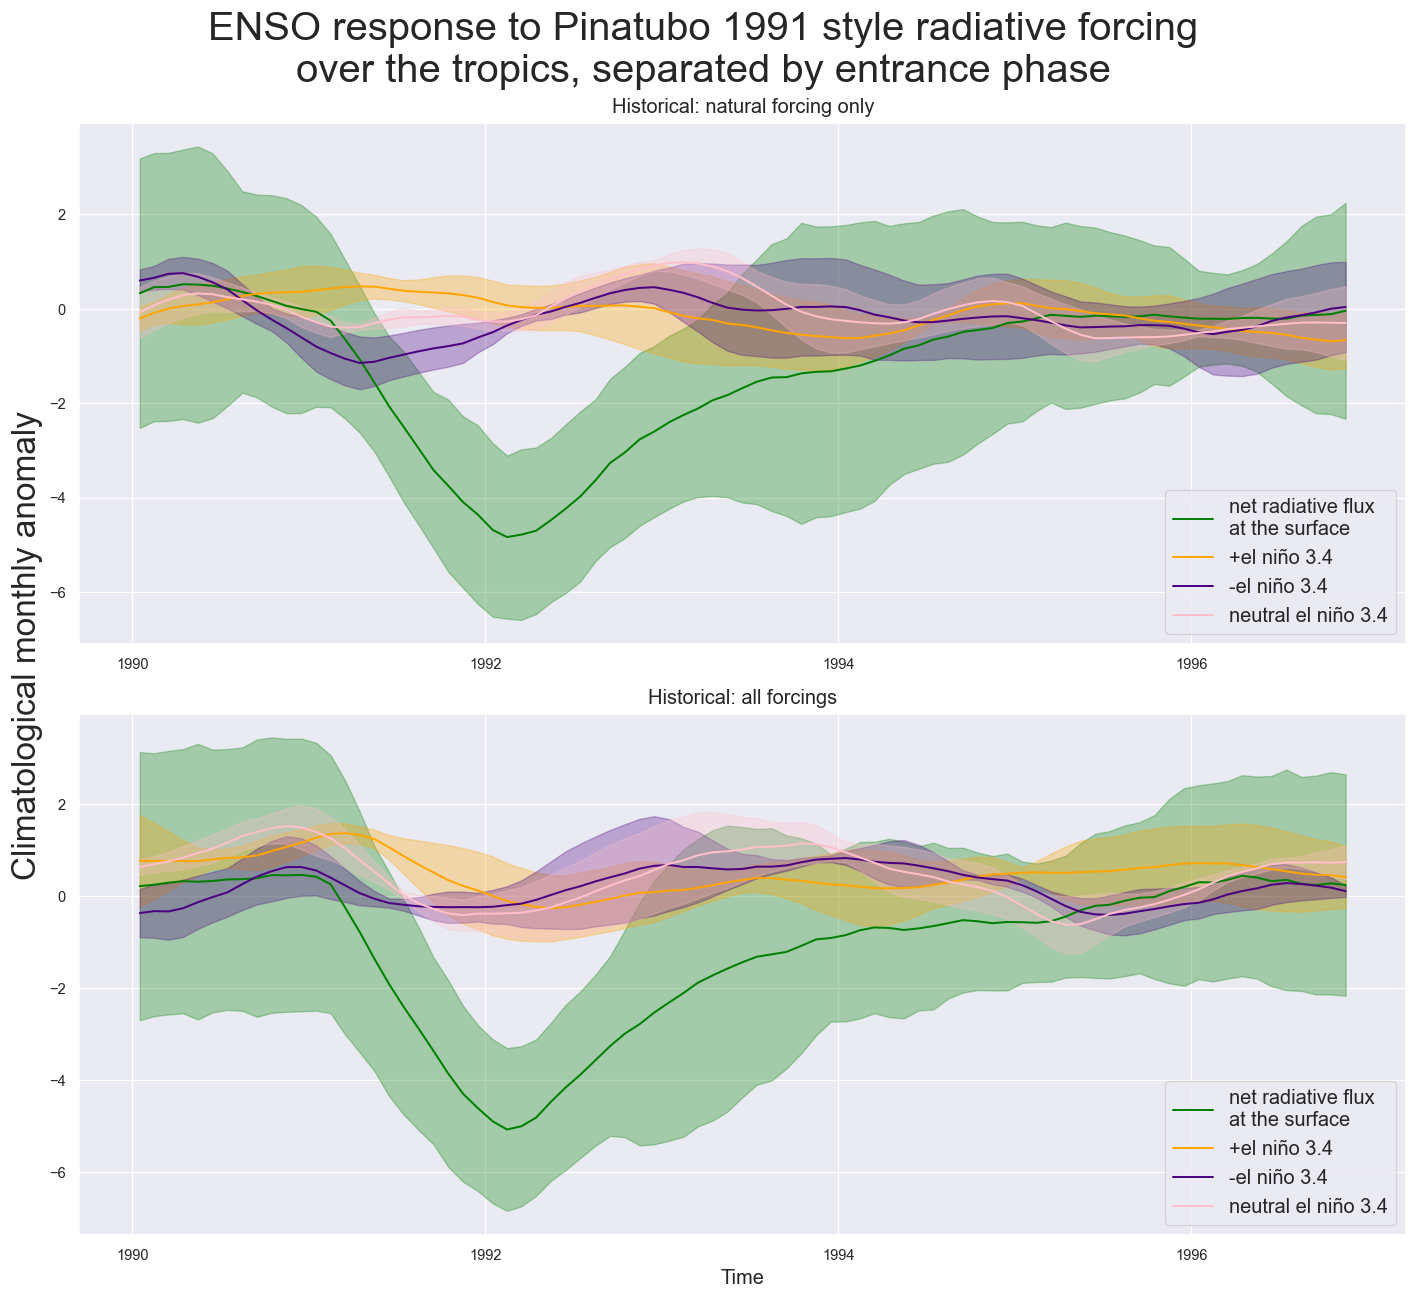

In [13]:
# HNAT

begin = '1990-01-01'
end = '1996-12-01'

fontsize = 12

# plot the ensemble mean and standard deviation
fig, ax = plt.subplots(2, 1, figsize=(12, 11), dpi=120)
ax[0].plot(
    hnat_ensemble.trfs_hnat.sel(time=slice(begin, end)).time.values,
    hnat_ensemble.trfs_hnat.sel(time=slice(begin, end)).values,
    label='net radiative flux\nat the surface', color='green')
ax[0].fill_between(hnat_ensemble.trfs_hnat.sel(time=slice(begin, end)).time.values,  
                 hnat_ensemble.trfs_hnat.sel(time=slice(begin, end)) - hnat_ensemble.trfs_hnat_std.sel(time=slice(begin, end)), 
                 hnat_ensemble.trfs_hnat.sel(time=slice(begin, end)) + hnat_ensemble.trfs_hnat_std.sel(time=slice(begin, end)), 
                 alpha=0.3, color='green')
ax[0].plot(
    hnat_ensemble.plus_hnat.sel(time=slice(begin, end)).time.values,
    hnat_ensemble.plus_hnat.sel(time=slice(begin, end)).values,
    label='+el niño 3.4', color='orange')
ax[0].fill_between(hnat_ensemble.plus_hnat.sel(time=slice(begin, end)).time.values,  
                 hnat_ensemble.plus_hnat.sel(time=slice(begin, end)) - hnat_ensemble.plus_hnat_std.sel(time=slice(begin, end)), 
                 hnat_ensemble.plus_hnat.sel(time=slice(begin, end)) + hnat_ensemble.plus_hnat_std.sel(time=slice(begin, end)), 
                 alpha=0.3, color='orange')
ax[0].plot(
    hnat_ensemble.minus_hnat.sel(time=slice(begin, end)).time.values,
    hnat_ensemble.minus_hnat.sel(time=slice(begin, end)).values,
    label='-el niño 3.4', color='indigo')
ax[0].fill_between(hnat_ensemble.minus_hnat.sel(time=slice(begin, end)).time.values,  
                 hnat_ensemble.minus_hnat.sel(time=slice(begin, end)) - hnat_ensemble.minus_hnat_std.sel(time=slice(begin, end)), 
                 hnat_ensemble.minus_hnat.sel(time=slice(begin, end)) + hnat_ensemble.minus_hnat_std.sel(time=slice(begin, end)), 
                 alpha=0.3, color='indigo')
ax[0].plot(
    hnat_ensemble.neut_hnat.sel(time=slice(begin, end)).time.values,
    hnat_ensemble.neut_hnat.sel(time=slice(begin, end)).values,
    label='neutral el niño 3.4', color='pink')
ax[0].fill_between(hnat_ensemble.neut_hnat.sel(time=slice(begin, end)).time.values,  
                 hnat_ensemble.neut_hnat.sel(time=slice(begin, end)) - hnat_ensemble.neut_hnat_std.sel(time=slice(begin, end)), 
                 hnat_ensemble.neut_hnat.sel(time=slice(begin, end)) + hnat_ensemble.neut_hnat_std.sel(time=slice(begin, end)), 
                 alpha=0.3, color='pink')

ax[0].legend(loc='lower right', fontsize=fontsize)

# HIST
ax[1].plot(
    hist_ensemble.trfs_hist.sel(time=slice(begin, end)).time.values,
    hist_ensemble.trfs_hist.sel(time=slice(begin, end)).values,
    label='net radiative flux\nat the surface', color='green')
ax[1].fill_between(hist_ensemble.trfs_hist.sel(time=slice(begin, end)).time.values,  
                 hist_ensemble.trfs_hist.sel(time=slice(begin, end)) - hist_ensemble.trfs_hist_std.sel(time=slice(begin, end)), 
                 hist_ensemble.trfs_hist.sel(time=slice(begin, end)) + hist_ensemble.trfs_hist_std.sel(time=slice(begin, end)), 
                 alpha=0.3, color='green')
ax[1].plot(
    hist_ensemble.plus_hist.sel(time=slice(begin, end)).time.values,
    hist_ensemble.plus_hist.sel(time=slice(begin, end)).values,
    label='+el niño 3.4', color='orange')
ax[1].fill_between(hist_ensemble.plus_hist.sel(time=slice(begin, end)).time.values,  
                 hist_ensemble.plus_hist.sel(time=slice(begin, end)) - hist_ensemble.plus_hist_std.sel(time=slice(begin, end)), 
                 hist_ensemble.plus_hist.sel(time=slice(begin, end)) + hist_ensemble.plus_hist_std.sel(time=slice(begin, end)), 
                 alpha=0.3, color='orange')
ax[1].plot(
    hist_ensemble.minus_hist.sel(time=slice(begin, end)).time.values,
    hist_ensemble.minus_hist.sel(time=slice(begin, end)).values,
    label='-el niño 3.4', color='indigo')
ax[1].fill_between(hist_ensemble.minus_hist.sel(time=slice(begin, end)).time.values,  
                 hist_ensemble.minus_hist.sel(time=slice(begin, end)) - hist_ensemble.minus_hist_std.sel(time=slice(begin, end)), 
                 hist_ensemble.minus_hist.sel(time=slice(begin, end)) + hist_ensemble.minus_hist_std.sel(time=slice(begin, end)), 
                 alpha=0.3, color='indigo')
ax[1].plot(
    hist_ensemble.neut_hist.sel(time=slice(begin, end)).time.values,
    hist_ensemble.neut_hist.sel(time=slice(begin, end)).values,
    label='neutral el niño 3.4', color='pink')
ax[1].fill_between(hist_ensemble.neut_hist.sel(time=slice(begin, end)).time.values,  
                 hist_ensemble.neut_hist.sel(time=slice(begin, end)) - hist_ensemble.neut_hist_std.sel(time=slice(begin, end)), 
                 hist_ensemble.neut_hist.sel(time=slice(begin, end)) + hist_ensemble.neut_hist_std.sel(time=slice(begin, end)), 
                 alpha=0.3, color='pink')

ax[1].legend(loc='lower right', fontsize=fontsize)


plt.suptitle("ENSO response to Pinatubo 1991 style radiative forcing\nover the tropics, separated by entrance phase", fontsize=24)
ax[0].set_title("Historical: natural forcing only", fontsize=fontsize)
ax[1].set_title("Historical: all forcings", fontsize=fontsize)
ax[1].set_xlabel("Time", fontsize=fontsize)
fig.supylabel('Climatological monthly anomaly', fontsize=20)

plt.tight_layout()
plt.savefig("test_vrf_uas_en34_separate_phases_1990_1996_timeseries.png")
plt.show()
